# Sensor Based Activity Recoginition 
Challenge: cdl1 - Sensor based Activity Recognition  
Team: Lea Bütler, Manjavy Kirupa, Etienne Roulet, Si Ben Tran  

Aufgabe: DL Modell erstellen

Hier in diesem Notebook erstellen wir unsere Deep Learning Modelle.

# Libraries Importieren & GPU Check

In [1]:
# General Libraries
import logging
from datetime import datetime
import os

# Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection as ms
from sklearn.model_selection import KFold, train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

# keras Libraries
from keras.utils import to_categorical

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

# dataclass
import dataclasses
from dataclasses import dataclass

# general setup
tf.debugging.set_log_device_placement(False)

# datetime as filename for logging
now = datetime.now()
date_time_string = now.strftime("%Y-%m-%d_%H-%M-%S")

logging.basicConfig(
    level=logging.INFO, filename=f"{date_time_string}.txt", filemode="a"
)
print(tf.config.list_physical_devices())

# Num of Gpus
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num GPUs Available:  0


# Daten einlesen

In [2]:
# Static Parameters
@dataclass
class Parameters:
    batch_size: int = 128
    epochs: int = 15
    verbosity: str = "auto"
    number_folds: int = 2
    output_size: int = 6
    window_size: int = 300
    step_size: int = 100

# Getrimmte Sensordaten einlesen
df = pd.read_csv("../Sensor_Data-Wrangling-und-EDA/Alle_Messungen_trimmed.csv", index_col=0)
display(df)

# convert the string time column to datetime
epoch = pd.Timestamp("1970-01-01")

# Time column into datetime
df["time"] = pd.to_datetime(df["time"])

# Time column into milliseconds
df["time"] = (df["time"] - epoch).apply(lambda x: int(x.total_seconds() * 1000))

,time,Accelerometer_x,Accelerometer_y,Accelerometer_z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Magnetometer_x,Magnetometer_y,Magnetometer_z,Orientation_qx,Orientation_qy,Orientation_qz,id,user,class,id_combined
1,2023-02-27 15:02:17.156,0.000000,9.722000,1.278000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.217750,-0.719579,0.631111,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
2,2023-02-27 15:02:31.574,-0.728000,9.779000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.420650,0.568356,-0.598058,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
3,2023-02-27 15:02:16.685,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.500000,-13.143750,0.000000,0.000000,0.000000,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
4,2023-02-27 15:02:32.295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.012501,0.000000,20.587502,0.000000,0.000000,0.000000,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
5,2023-02-27 15:02:33.285,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-22.612501,0.000000,20.268751,0.000000,0.000000,0.000000,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539029,2023-03-11 13:11:56.901,2.507094,4.691251,-0.583939,0.246416,0.067954,0.365369,-4.043274,6.146469,44.221630,0.959304,-0.001751,0.282337,9_iphone13mini-2023-03-11_13-09-56,Weiping_Zhang,Velofahren,9_iphone13mini-2023-03-11_13-09-56Weiping_Zhan...
2539030,2023-03-11 13:11:56.911,1.888469,3.766656,-0.826295,0.196101,0.019053,0.352243,-3.925354,6.195618,44.229263,0.959236,-0.003181,0.282578,9_iphone13mini-2023-03-11_13-09-56,Weiping_Zhang,Velofahren,9_iphone13mini-2023-03-11_13-09-56Weiping_Zhan...
2539031,2023-03-11 13:11:56.921,0.994240,3.075035,-0.740944,0.105015,-0.027495,0.306060,-3.801758,6.023056,43.900330,0.959244,-0.004561,0.282538,9_iphone13mini-2023-03-11_13-09-56,Weiping_Zhang,Velofahren,9_iphone13mini-2023-03-11_13-09-56Weiping_Zhan...
2539032,2023-03-11 13:11:56.931,0.423654,2.433349,-0.432823,-0.027677,0.027132,0.250502,-3.830048,6.086670,43.879021,0.959245,-0.005843,0.282515,9_iphone13mini-2023-03-11_13-09-56,Weiping_Zhang,Velofahren,9_iphone13mini-2023-03-11_13-09-56Weiping_Zhan...


# Preprocessing Data

## Create Validation Data

In [3]:
# select three random id_combines files
ids = ["06_iPhone12-2023-03-16_13-46-58Manjavy_KirupaVelofahren", 
       "01_iPhone13pro-2023-03-21_16-55-47Etienne_RouletLaufen", 
       "01_iPhone13ProMax-2023-03-15_18-29-42Gabriel_TorresRennen"]

# create a dataframe with these three random files
df_validation = df[df["id_combined"].isin(ids)]

# export the dataframe as a csv file
df_validation.to_csv("validation-velo-laufen-rennen.csv", index=False)

# remove the validation data from the dataframe 
df = df[~df["id_combined"].isin(ids)]

## Drop unnötige Spalten und Class Encoden

In [4]:
# drop the columns that are not needed
df = df.drop(columns=["id", "user", "id_combined"])
# get all types of the df
le = LabelEncoder()
# encode the classes
df["class"] = le.fit_transform(df["class"])
# print dictionary of the classes and its encoded values
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Laufen': 0, 'Rennen': 1, 'Sitzen': 2, 'Stehen': 3, 'Treppenlaufen': 4, 'Velofahren': 5}


## Daten Transformation

In [5]:
# Set the window size and step size
window_size = Parameters.window_size
step_size = Parameters.step_size

# Reshape X to 2D format (samples, features)
X = df.values[:, 1:13]

# Define y
y = df["class"].values

# Create a sliding window of X with the specified window and step sizes
X_windows = np.array(
    [
        X[i : i + window_size, :]
        for i in range(0, X.shape[0] - window_size + 1, step_size)
    ]
)

# Reshape X_windows to 3D format (samples, timesteps, features)
timesteps = X_windows.shape[1]
n_features = X_windows.shape[2]
X_windows = X_windows.reshape(-1, timesteps, n_features)

# Create the corresponding y labels for the sliding windows
y_windows = np.array(
    [y[i + window_size - 1] for i in range(0, X.shape[0] - window_size + 1, step_size)]
)
y_windows = to_categorical(y_windows, num_classes=6)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    X_windows, y_windows, test_size=0.1, random_state=42, stratify=y_windows
)

# print Data shapes
print("Data shapes:")
print("- X:         = {}".format(X.shape))
print("- y:         = {}".format(y.shape))
print("- X_train:   = {}".format(x_train.shape))
print("- y_train:   = {}".format(y_train.shape))
print("- X_test:    = {}".format(x_test.shape))
print("- y_test:    = {}".format(y_test.shape))

Data shapes:
- X:         = (2306798, 12)
- y:         = (2306798,)
- X_train:   = (20758, 300, 12)
- y_train:   = (20758, 6)
- X_test:    = (2307, 300, 12)
- y_test:    = (2307, 6)


# DL-Modelle erstellen

In [6]:
# Creating Deep Learning Models

def create_model_1(name="model_1"):
    '''
    CNN Model with 1 Convolutional Layer, 1 LSTM Layer and 1 Dense Layer 
    '''
    model = tf.keras.Sequential(
        [
            # Add a 1D convolutional layer
            tf.keras.layers.Conv1D(
                filters=64,
                kernel_size=12,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            # Add LSTM layer
            tf.keras.layers.LSTM(100),
            # Add a dense output layer
            tf.keras.layers.Dense(
                6, activation="softmax"
            ),  # Change activation function based on the nature of the output
        ],
        name=name,
    )
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model


def create_model_2(name="model_2"):
    '''
    CNN Model with one Conv1D layer, one LSTM layer and one Dense layer, also using l2 regularization and dropout
    '''
    model = tf.keras.Sequential(
        [
            # Add a 1D convolutional layer
            tf.keras.layers.Conv1D(
                filters=32,
                kernel_size=8,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(0.001),
            ),
            # Add LSTM layer
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200)),
            tf.keras.layers.Dropout(0.5),

            # Add a dense output layer
            tf.keras.layers.Dense(
                6, activation="softmax"
            ),  # Change activation function based on the nature of the output
        ],
        name=name,
    )
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model


def create_model_3(name="model_3"):
    '''
    CNN Model with 32 Filters combine with LSTM and one dense layer
    '''
    model = tf.keras.Sequential(
        [
            # Add a 1D convolutional layer
            tf.keras.layers.Conv1D(
                filters=32,
                kernel_size=2,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            # Add LSTM layer
            tf.keras.layers.LSTM(100),
            # Add a dense output layer
            tf.keras.layers.Dense(
                6, activation="softmax"
            ),  # Change activation function based on the nature of the output
        ],
        name=name,
    )
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model


def create_model_4(name="model_4"):
    '''
    CNN Model with 64 Filters combined with LSTM and one dense layer
    '''
    model = tf.keras.Sequential(
        [
            # Add a 1D convolutional layer
            tf.keras.layers.Conv1D(
                filters=64,
                kernel_size=2,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            # Add LSTM layer
            tf.keras.layers.LSTM(100),
            # Add a dense output layer
            tf.keras.layers.Dense(
                6, activation="softmax"
            ),  # Change activation function based on the nature of the output
        ],
        name=name,
    )
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model


def create_model_5(name="model_5"):
    '''
    CNN Model with 3 Conv1D Layers and 2 Dense Layers with Batch Normalization and L2 Regularization
    '''
    model = tf.keras.Sequential(
        [
            # First Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=32,
                kernel_size=2,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Second Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=20, 
                kernel_size=2, 
                activation="relu", 
                padding="same",
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Third Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=10, 
                kernel_size=2, 
                activation="relu", 
                padding="same", 
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Flatten the results
            tf.keras.layers.Flatten(),
            # Add first dense layer
            tf.keras.layers.Dense(units = 200, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01),),
            tf.keras.layers.BatchNormalization(),
            # Add second dense layer
            tf.keras.layers.Dense(units = 100, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01),),
            tf.keras.layers.BatchNormalization(),
            # Add output Layer with Softmax Activation Funktion
            tf.keras.layers.Dense(units = 6, 
                                  activation="softmax"),
        ],
        name=name,
    )
    # Define optimizer, loss and metrics 
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model


def create_model_6(name="model_6"):
    '''
    CNN Model with 2 Conv1D Layers and 3 Dense Layers with Batch Normalization and L2 Regularization
    '''
    model = tf.keras.Sequential(
        [
            # First Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=64,
                kernel_size=2,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Second Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=32, 
                kernel_size=2, 
                activation="relu", 
                padding="same",
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Flatten the results
            tf.keras.layers.Flatten(),
            # Add first dense layer
            tf.keras.layers.Dense(units = 200, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01),),
            tf.keras.layers.BatchNormalization(),
            # Add second dense layer
            tf.keras.layers.Dense(units = 100, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01),),
            tf.keras.layers.BatchNormalization(),
            # Add third dense layer
            tf.keras.layers.Dense(units = 50, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01),),
            tf.keras.layers.BatchNormalization(),
            # Add output Layer with Softmax Activation Funktion
            tf.keras.layers.Dense(units = 6, 
                                  activation="softmax"),
        ],
        name=name,
    )
    # Define optimizer, loss and metrics 
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model


def create_model_7(name="model_7", 
                   filterconv1 = 64, 
                   filterconv2 = 64, 
                   filterconv3 = 64, 
                   filterconv4 = 64,
                   filterconv5 = 64, 
                   unitsdense1 = 200, 
                   unitsdense2 = 150, 
                   unitsdense3 = 100,
                   unitsdense4 = 50,
                   unitsdense5 = 25,
                   l2_reg = 0.05):
    '''
    Check, if the deeper the model the better the results? 
    CNN Model with 5 Conv1D Layers and 5 Dense Layers with Batch Normalization and L2 Regularization
    '''
    model = tf.keras.Sequential(
        [
            # First Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=filterconv1,
                kernel_size=2,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            ),
            # Batchnormalization and Maxpooling
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Second Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=filterconv2, 
                kernel_size=2, 
                activation="relu", 
                padding="same",
                kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            ),
            # Batchnormalization and Maxpooling
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Third Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=filterconv3, 
                kernel_size=2, 
                activation="relu", 
                padding="same",
                kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            ),
            # Batchnormalization and Maxpooling
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Fourth Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=filterconv4,
                kernel_size=2,
                activation="relu",
                padding="same",
                kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            ),
            # Batchnormalization and Maxpooling
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Fifth Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=filterconv5,
                kernel_size=2,
                activation="relu",
                padding="same",
                kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            ),
            # Batchnormalization and Maxpooling
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Flatten the results
            tf.keras.layers.Flatten(),
            # Add first dense layer
            tf.keras.layers.Dense(units = unitsdense1, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg),),
            tf.keras.layers.BatchNormalization(),
            # Add second dense layer
            tf.keras.layers.Dense(units = unitsdense2, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg),),
            tf.keras.layers.BatchNormalization(),
            # Add third dense layer
            tf.keras.layers.Dense(units = unitsdense3, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg),),
            tf.keras.layers.BatchNormalization(),
            # Add fourth dense layer
            tf.keras.layers.Dense(units = unitsdense4,
                                  activation="relu",
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg),),
            tf.keras.layers.BatchNormalization(),
            # add fifth dense layer
            tf.keras.layers.Dense(units = unitsdense5,
                                  activation="relu",
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg),),
            tf.keras.layers.BatchNormalization(),
        
            # Add output Layer with Softmax Activation Funktion
            tf.keras.layers.Dense(units = 6, 
                                  activation="softmax"),
        ],
        name=name,
    )
    # Define optimizer, loss and metrics 
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

# DL-Modelle Trainieren

In [7]:
best_model_history = None  # Keep track of the best model's history
model_histories = []
models = [create_model_6] # Add all models to this list
best_model = None
num_folds = Parameters.number_folds
tscv = TimeSeriesSplit(n_splits=num_folds)
fold_acc_scores = []

for i, (train, test) in enumerate(tscv.split(x_train)):
    logging.info(f"Fold {i+1}")
    train_x, train_y = x_train[train], y_train[train]
    test_x, test_y = x_train[test], y_train[test]

    fold_histories = []

    for j, model_creator in enumerate(models):
        print(f"Model {model_creator.__name__}")
        model_name = f"Model_{j+1}_Fold_{i+1}"
        model = model_creator(name=model_name)
        logging.info(f"Model {j+1}")
        history = model.fit(
            train_x,
            train_y,
            epochs=Parameters.epochs,
            batch_size=Parameters.batch_size,
            validation_data=(test_x, test_y),
            verbose=Parameters.verbosity,
        )
        test_loss, acc, prec, recal = model.evaluate(
            test_x, test_y, verbose=Parameters.verbosity
        )
        logging.info(f"Validation accuracy: {acc}")

        fold_histories.append(history.history)

        for epoch in range(Parameters.epochs):
            # Log accuracy after each epoch
            acc_epoch = history.history["val_accuracy"][epoch]
            logging.info(f"Epoch {epoch + 1}, Validation accuracy: {acc_epoch}")
        fold_acc_scores.append((i, j, acc))

        if best_model_history is None or acc > best_model_acc:
            best_model_history = history
            best_model = model  # Store the trained model instance
            best_model_acc = acc

    model_histories.append(fold_histories)

# Find the best model
best_model_index = np.argmax([score[2] for score in fold_acc_scores])
best_fold_idx, best_model_idx, _ = max(fold_acc_scores, key=lambda x: x[2])
best_model_history = model_histories[best_fold_idx][best_model_idx]
print(best_model.name)

Model create_model_6
Epoch 1/15
55/55 [==============================] - 8s 92ms/step - loss: 6.2439 - accuracy: 0.7295 - precision: 0.8200 - recall: 0.6379 - val_loss: 6.0424 - val_accuracy: 0.3726 - val_precision: 0.4451 - val_recall: 0.3170
Epoch 2/15
55/55 [==============================] - 4s 77ms/step - loss: 4.0336 - accuracy: 0.8601 - precision: 0.8899 - recall: 0.8221 - val_loss: 3.9959 - val_accuracy: 0.6020 - val_precision: 0.6915 - val_recall: 0.4418
Epoch 3/15
55/55 [==============================] - 4s 76ms/step - loss: 2.8706 - accuracy: 0.8829 - precision: 0.9024 - recall: 0.8581 - val_loss: 2.7703 - val_accuracy: 0.7835 - val_precision: 0.8851 - val_recall: 0.6903
Epoch 4/15
55/55 [==============================] - 4s 76ms/step - loss: 2.2438 - accuracy: 0.8910 - precision: 0.9051 - recall: 0.8753 - val_loss: 2.2056 - val_accuracy: 0.8597 - val_precision: 0.9160 - val_recall: 0.7790
Epoch 5/15
55/55 [==============================] - 4s 76ms/step - loss: 1.8357 - accur

## Verlauf von Accuracy und Loss

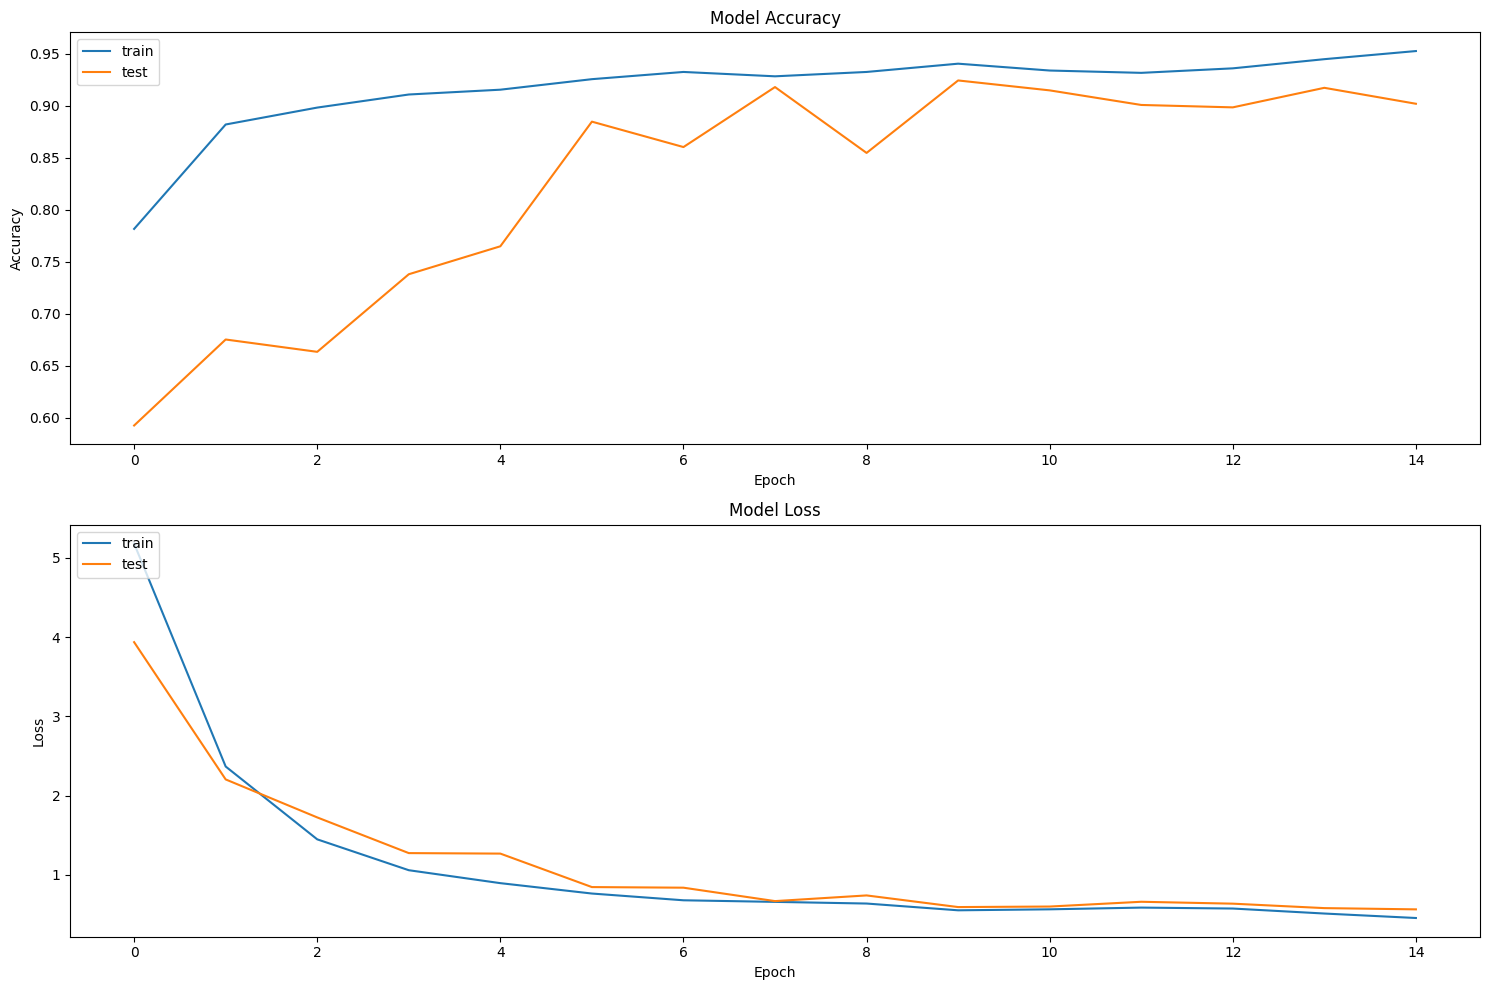

In [8]:
# Create 2 subplots one for model accuracy and another for model loss
fig, axs = plt.subplots(2, figsize=(15, 10))
# Summarize history for accuracy
axs[0].plot(best_model_history["accuracy"])
axs[0].plot(best_model_history["val_accuracy"])
axs[0].set_title("Model Accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].legend(["train", "test"], loc="upper left")
# Summarize history for loss
axs[1].plot(best_model_history["loss"])
axs[1].plot(best_model_history["val_loss"])
axs[1].set_title("Model Loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].legend(["train", "test"], loc="upper left")
plt.tight_layout()
plt.show()


## Confusions Matrix

649/649 [==============================] - 3s 4ms/step


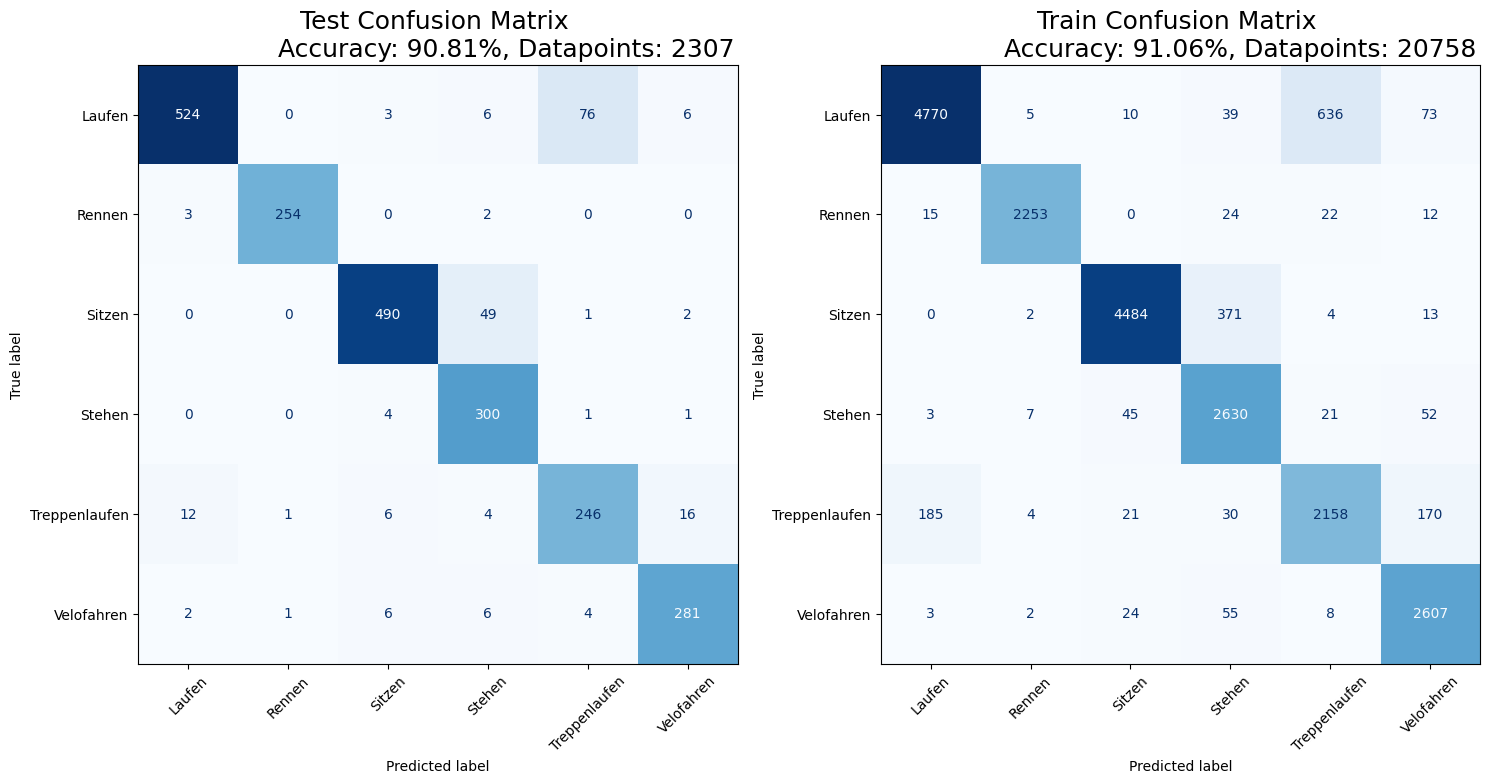

In [9]:
# Create for x_train and x_test confusion matrix
y_pred = best_model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true = y_test_labels, y_pred = y_pred_labels)

cm = confusion_matrix(y_true = y_test_labels, y_pred = y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Create subplot for test confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))
disp.plot(cmap=plt.cm.Blues, ax=ax1, colorbar=False)
ax1.set_title("Test Confusion Matrix \n \
                Accuracy: {:.2f}%, Datapoints: {}".format(accuracy * 100, x_test.shape[0]), fontsize=18)
ax1.set_xticklabels(le.classes_, rotation=45)

# Create for x_train and x_test confusion matrix
y_pred = best_model.predict(x_train)
y_pred_labels = np.argmax(y_pred, axis=1)
y_train_labels = np.argmax(y_train, axis=1)

accuracy = accuracy_score(y_true = y_train_labels, y_pred = y_pred_labels)
cm = confusion_matrix(y_true = y_train_labels, y_pred = y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Create subplot for train confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax2, colorbar=False)
# add to title number of observations
ax2.set_title("Train Confusion Matrix \n \
              Accuracy: {:.2f}%, Datapoints: {}".format(accuracy * 100, x_train.shape[0]), fontsize=18)

ax2.set_xticklabels(le.classes_, rotation=45)

plt.tight_layout()
plt.show()


# Export DL-Modell

In [10]:
# export Model to json Tensorflow file
import json

best_model.save("saved_model/sensor_model.h5")

model = tf.keras.models.load_model("saved_model/sensor_model.h5")

# Save model architecture to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to a JSON file
weights = model.get_weights()
weights_as_list = [w.tolist() for w in weights]
with open("weights.json", "w") as f:
    json.dump(weights_as_list, f)

# Modell Einlesen und predicten auf Testdaten

In [11]:

class validate_unseen_data():
    def __init__(self, model_path="saved_model/sensor_model.h5"):
        self.model = tf.keras.models.load_model(model_path)
        self.csv_path = "validation-velo-laufen-rennen.csv"
        
    def predict_classes(self, file="06_iPhone12-2023-03-16_13-46-58Manjavy_KirupaVelofahren", expected=''):
        df_val = pd.read_csv(self.csv_path)
        # Filter the rows where its velo in id_combined
        df_val = df_val[df_val["id_combined"].str.contains(file)]
        df_val = df_val.drop(columns=["id", "user", "id_combined"])
        # convert the string time column to datetime
        epoch = pd.Timestamp("1970-01-01")
        df_val["time"] = pd.to_datetime(df_val["time"])
        df_val["time"] = (df_val["time"] - epoch).apply(
            lambda x: int(x.total_seconds() * 1000)
        )
        # get all types of the df
        le = LabelEncoder()
        df_val["class"] = le.fit_transform(df_val["class"])

        # Set the window size and step size
        window_size = 300
        step_size = 100

        # Reshape X to 2D format (samples, features)
        X = df_val.values[:, 1:13]
        y = df["class"].values

        # Create a sliding window of X with the specified window and step sizes
        X_windows = np.array(
            [
                X[i : i + window_size, :]
                for i in range(0, X.shape[0] - window_size + 1, step_size)
            ]
        )

        # Reshape X_windows to 3D format (samples, timesteps, features)
        timesteps = X_windows.shape[1]
        n_features = X_windows.shape[2]
        X_windows = X_windows.reshape(-1, timesteps, n_features)

        # Create the corresponding y labels for the sliding windows
        y_windows = np.array(
            [y[i + window_size - 1] for i in range(0, X.shape[0] - window_size + 1, step_size)]
        )
        y_windows = to_categorical(y_windows, num_classes=6)

        # predict validation data
        y_pred_probs = model.predict(X_windows)

        # Get the predicted class labels for each input window
        y_pred_labels = np.argmax(y_pred_probs, axis=1)

        # Print the predicted class labels
        # get the median of the predicted labels
        sol = np.median(y_pred_labels)

        class_counts = np.bincount(y_pred_labels)
        for i, count in enumerate(class_counts):
            print(f"Class {i} count: {count}")
        
        return (sol, expected)

median = validate_unseen_data().predict_classes('06_iPhone12-2023-03-16_13-46-58Manjavy_KirupaVelofahren', expected='velo')
median2 = validate_unseen_data().predict_classes('01_iPhone13ProMax-2023-03-15_18-29-42Gabriel_TorresRennen', expected='rennen')
median3 = validate_unseen_data().predict_classes('01_iPhone13pro-2023-03-21_16-55-47Etienne_RouletLaufen', expected='laufen')

print((median, median2, median3))



print(dict(zip(le.classes_, le.transform(le.classes_))))

2/2 [==============================] - 0s 6ms/step
Class 0 count: 0
Class 1 count: 0
Class 2 count: 0
Class 3 count: 0
Class 4 count: 0
Class 5 count: 56
8/8 [==============================] - 0s 5ms/step
Class 0 count: 0
Class 1 count: 238
Class 2 count: 1
Class 3 count: 6
Class 4 count: 3
3/3 [==============================] - 0s 3ms/step
Class 0 count: 29
Class 1 count: 0
Class 2 count: 0
Class 3 count: 0
Class 4 count: 21
Class 5 count: 15
((5.0, 'velo'), (1.0, 'rennen'), (4.0, 'laufen'))
{'Laufen': 0, 'Rennen': 1, 'Sitzen': 2, 'Stehen': 3, 'Treppenlaufen': 4, 'Velofahren': 5}


In [12]:
# the Conclusion is that the model is not overfitted but Gabriel is more a Stepper than a Runner ;)